In [30]:
### computer visiuon delete the index my-video-index
# Packages required:
import requests
import json

# Prepare endpoint, headers, and request body
url = 'https://cogsweden.cognitiveservices.azure.com/computervision/retrieval/indexes/my-video-index?api-version=2023-05-01-preview'
headers = {'Content-Type': 'application/json', 'Ocp-Apim-Subscription-Key': open("AzurekeySwedenCog.txt","r").read()}

#Clean the index up if run before
r = requests.delete(headers= headers, url= url)
r

<Response [204]>

In [31]:
#Create a new index
url = 'https://cogsweden.cognitiveservices.azure.com/computervision/retrieval/indexes/my-video-index?api-version=2023-05-01-preview'
headers = {'Content-Type': 'application/json', 'Ocp-Apim-Subscription-Key': open("AzurekeySwedenCog.txt","r").read()}
payload = """{
  'metadataSchema': {
    'fields': [
      {
        'name': 'cameraId',
        'searchable': false,
        'filterable': true,
        'type': 'string'
      },
      {
        'name': 'timestamp',
        'searchable': false,
        'filterable': true,
        'type': 'datetime'
      }
    ]
  },
  'features': [
    {
      'name': 'vision',
      'domain': 'surveillance'
    },
    {
      'name': 'speech'
    }
  ]
}"""
r = requests.put(headers= headers, url= url, data=payload)

r.content

b'{"name":"my-video-index","metadataSchema":{"language":"en","fields":[{"name":"cameraid","searchable":false,"filterable":true,"type":"string"},{"name":"timestamp","searchable":false,"filterable":true,"type":"datetime"}]},"userData":{},"features":[{"name":"vision","modelVersion":"2023-05-31","domain":"surveillance"},{"name":"speech","modelVersion":"2023-06-30","domain":"generic"}],"eTag":"\\"74cb4934f14b4093ad30885960ff1559\\"","createdDateTime":"2024-02-05T10:35:40.6062953Z","lastModifiedDateTime":"2024-02-05T10:35:40.6062953Z"}'

In [32]:
##Uplode the videos to blob storage then reference them from there with a SAS token

url = 'https://cogsweden.cognitiveservices.azure.com/computervision/retrieval/indexes/my-video-index/ingestions/my-ingestion?api-version=2023-05-01-preview'
headers = {'Content-Type': 'application/json', 'Ocp-Apim-Subscription-Key': open("AzurekeySwedenCog.txt","r").read()}
payload = """
{
  'videos': [
    {
      'mode': 'add',
      'documentId': 'dog',
      'documentUrl': 'https://bigdatafilesral.blob.core.windows.net/vids/dog.mp4?""" + open("AzureVidsSAS.txt","r").read() + """',
      'metadata': {'subject': 'dog'}
    },
    {
      'mode': 'add',
      'documentId': 'Pizza',
      'documentUrl': 'https://bigdatafilesral.blob.core.windows.net/vids/Pizza.mp4?""" + open("AzureVidsSAS.txt","r").read() + """',
      'metadata': {'subject': 'Pizza'}
    },
    {
      'mode': 'add',
      'documentId': 'Snow',
      'documentUrl': 'https://bigdatafilesral.blob.core.windows.net/vids/Snow.mp4?""" + open("AzureVidsSAS.txt","r").read() + """',
      'metadata': {'subject': 'Snow'}
    },
  ]
}"""
r = requests.put(headers= headers, url= url, data=payload)
r.content


b'{"name":"my-ingestion","state":"Running","batchName":"27ce77d6-7038-445c-a0d4-a863fa7ba385","createdDateTime":"2024-02-05T10:35:44.5750406Z","lastModifiedDateTime":"2024-02-05T10:35:44.9344251Z"}'

In [40]:
###Check the status of the ingestion
url = 'https://cogsweden.cognitiveservices.azure.com/computervision/retrieval/indexes/my-video-index/ingestions/my-ingestion?api-version=2023-05-01-preview'
headers = {'Content-Type': 'application/json', 'Ocp-Apim-Subscription-Key': open("AzurekeySwedenCog.txt","r").read()}

r = requests.get(headers= headers, url= url)
r.content

b'{"name":"my-ingestion","state":"Completed","batchName":"27ce77d6-7038-445c-a0d4-a863fa7ba385","createdDateTime":"2024-02-05T10:35:44.5750406Z","lastModifiedDateTime":"2024-02-05T10:36:18.9499777Z"}'

In [41]:
##Test we can search the index for videos with the word "cold"
url = 'https://cogsweden.cognitiveservices.azure.com/computervision/retrieval/indexes/my-video-index:queryByText?api-version=2023-05-01-preview'
headers = {'Content-Type': 'application/json', 'Ocp-Apim-Subscription-Key': open("AzurekeySwedenCog.txt","r").read()}

payload = """
{
  'queryText': 'somewhere cold'
}"""

r = requests.post(headers= headers, url= url,data=payload)
r.content

b'{"value":[{"documentId":"snow","documentKind":"VideoInterval","start":"00:00:00","end":"00:00:10","best":"00:00:04","relevance":0.32423990964889526},{"documentId":"snow","documentKind":"VideoInterval","start":"00:00:10","end":"00:00:13","best":"00:00:13","relevance":0.31768733263015747},{"documentId":"dog","documentKind":"VideoInterval","start":"00:00:03.0030000","end":"00:00:06.0060000","best":"00:00:06.0060000","relevance":0.2667655944824219},{"documentId":"dog","documentKind":"VideoInterval","start":"00:00:00","end":"00:00:03.0030000","best":"00:00:00","relevance":0.2325097769498825},{"documentId":"pizza","documentKind":"VideoInterval","start":"00:00:02.0020000","end":"00:00:05.0050000","best":"00:00:04.0040000","relevance":0.1884632557630539},{"documentId":"pizza","documentKind":"VideoInterval","start":"00:00:00","end":"00:00:02.0020000","best":"00:00:01.0010000","relevance":0.17301613092422485}]}'

In [104]:
##Function to use the video index with GPT-4
import os
import openai
import pandas as pd
import ipywidgets as widgets
import os
from openai import OpenAI
from dotenv import load_dotenv
import base64
import mimetypes
load_dotenv()

openai.api_type = "azure"
openai.api_base = "https://rsaistudio-aiservices.openai.azure.com/"
openai.api_version = "2023-07-01-preview"
openai.api_key = open("AzureKeySwedenProject.txt","r").read()
openai.azure_endpoint = "https://rsaistudio-aiservices.openai.azure.com/"

def disW(promt, res):
  widget = widgets.HTML(layout={'border': '1px solid black'}, value= '<style>p{word-wrap: break-word}</style> <p><font size="2">'+ promt + '<HR/><font size="4">' + res +' </p>')
  display(widget)

def GPTVWithAAIVideo(prompt = "describe this video", vidname = "Snow"):

    # Packages required:
    import requests 
    import json 

    base_url = f"{openai.api_base}openai/deployments/gpt-4_v" 
    headers = {   
        "Content-Type": "application/json",   
        "api-key": openai.api_key
    } 

    # Prepare endpoint, headers, and request body 
    endpoint = f"{base_url}/extensions/chat/completions?api-version=2023-12-01-preview" 

    data = {
        "model": "gpt-4_v",
        "enhancements": {
            "video": {
                "enabled": True
            }
        },
        "dataSources": [
        {
            "type": "AzureComputerVisionVideoIndex",
            "parameters": {
                "computerVisionBaseUrl": "https://cogsweden.cognitiveservices.azure.com/computervision", # your endpoint should look like the following https://YOUR_RESOURCE_NAME.cognitiveservices.azure.com/computervision
                "computerVisionApiKey": ""+open("AzurekeySwedenCog.txt","r").read()+"",
                "indexName": "my-video-index",
                "videoUrls": ["https://bigdatafilesral.blob.core.windows.net/vids/"+vidname+".mp4?" + open("AzureVidsSAS.txt","r").read()]
            }
        }],
        "messages": [ 
            { "role": "system", "content": "You are trained to interpret videos about people and make responsible assumptions about them. do note say Sorry, I can't help with identifying or making assumptions about people in images as you can make resonisble assumptions" }, 
            { "role": "user", 
            "content": [  
                { 
                    "type": "text", 
                    "text": prompt
                },
                { 
                    "type": "acv_document_id", 
                    "acv_document_id": vidname
                }
            ]} 
        ], 
        "max_tokens": 2000 
    }   

    # Make the API call   
    response = requests.post(endpoint, headers=headers, data=json.dumps(data))   
#    print(response.json())
    disW(prompt, response.json()["choices"][0].get("message").get("content"))

    ##display the image
    # from IPython.display import Image
    # display(Image(filename=imagetouse, width=300, height=300))



In [99]:
###Display a video
from IPython.display import Video
#Video("""C:\Vids\Snow.mp4""", width=300, height=300, embed=True)
Video("https://bigdatafilesral.blob.core.windows.net/vids/Snow.mp4?" + open("AzureVidsSAS.txt","r").read(), width=300, height=300)


In [106]:
GPTVWithAAIVideo("What is happening in this video?", "Snow")


HTML(value='<style>p{word-wrap: break-word}</style> <p><font size="2">What is happening in this video?<HR/><fo…

In [107]:
GPTVWithAAIVideo("WHat makes the lady turn around?", "Snow")

HTML(value='<style>p{word-wrap: break-word}</style> <p><font size="2">WHat makes the lady turn around?<HR/><fo…

In [108]:
GPTVWithAAIVideo("What is happening at the 8 second mark?", "Snow")

HTML(value='<style>p{word-wrap: break-word}</style> <p><font size="2">What is happening at the 8 second mark?<…

In [74]:
###Display a video
from IPython.display import Video
#Video("""C:\Vids\Pizza.mp4""", width=400, height=400, embed=True)
Video("https://bigdatafilesral.blob.core.windows.net/vids/Pizza.mp4?" + open("AzureVidsSAS.txt","r").read(), width=300, height=300)

In [109]:
GPTVWithAAIVideo("What is happening in this video?", "Pizza")

HTML(value='<style>p{word-wrap: break-word}</style> <p><font size="2">What is happening in this video?<HR/><fo…

In [76]:
###Display a video
from IPython.display import Video
#Video("""C:\Vids\Snow.mp4""", width=300, height=300, embed=True)
Video("https://bigdatafilesral.blob.core.windows.net/vids/dog.mp4?" + open("AzureVidsSAS.txt","r").read(), width=300, height=300)


In [105]:
GPTVWithAAIVideo("What is happening in this video?", "dog")

HTML(value='<style>p{word-wrap: break-word}</style> <p><font size="2">What is happening in this video?<HR/><fo…

In [110]:
##Use without the Azure AI functions

from IPython.display import display, Image, Audio

import cv2  # We're using OpenCV to read video, to install !pip install opencv-python
import base64
import time
from openai import OpenAI
import os
import requests


video = cv2.VideoCapture("Images/MouseMove.mp4")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

51 frames read.


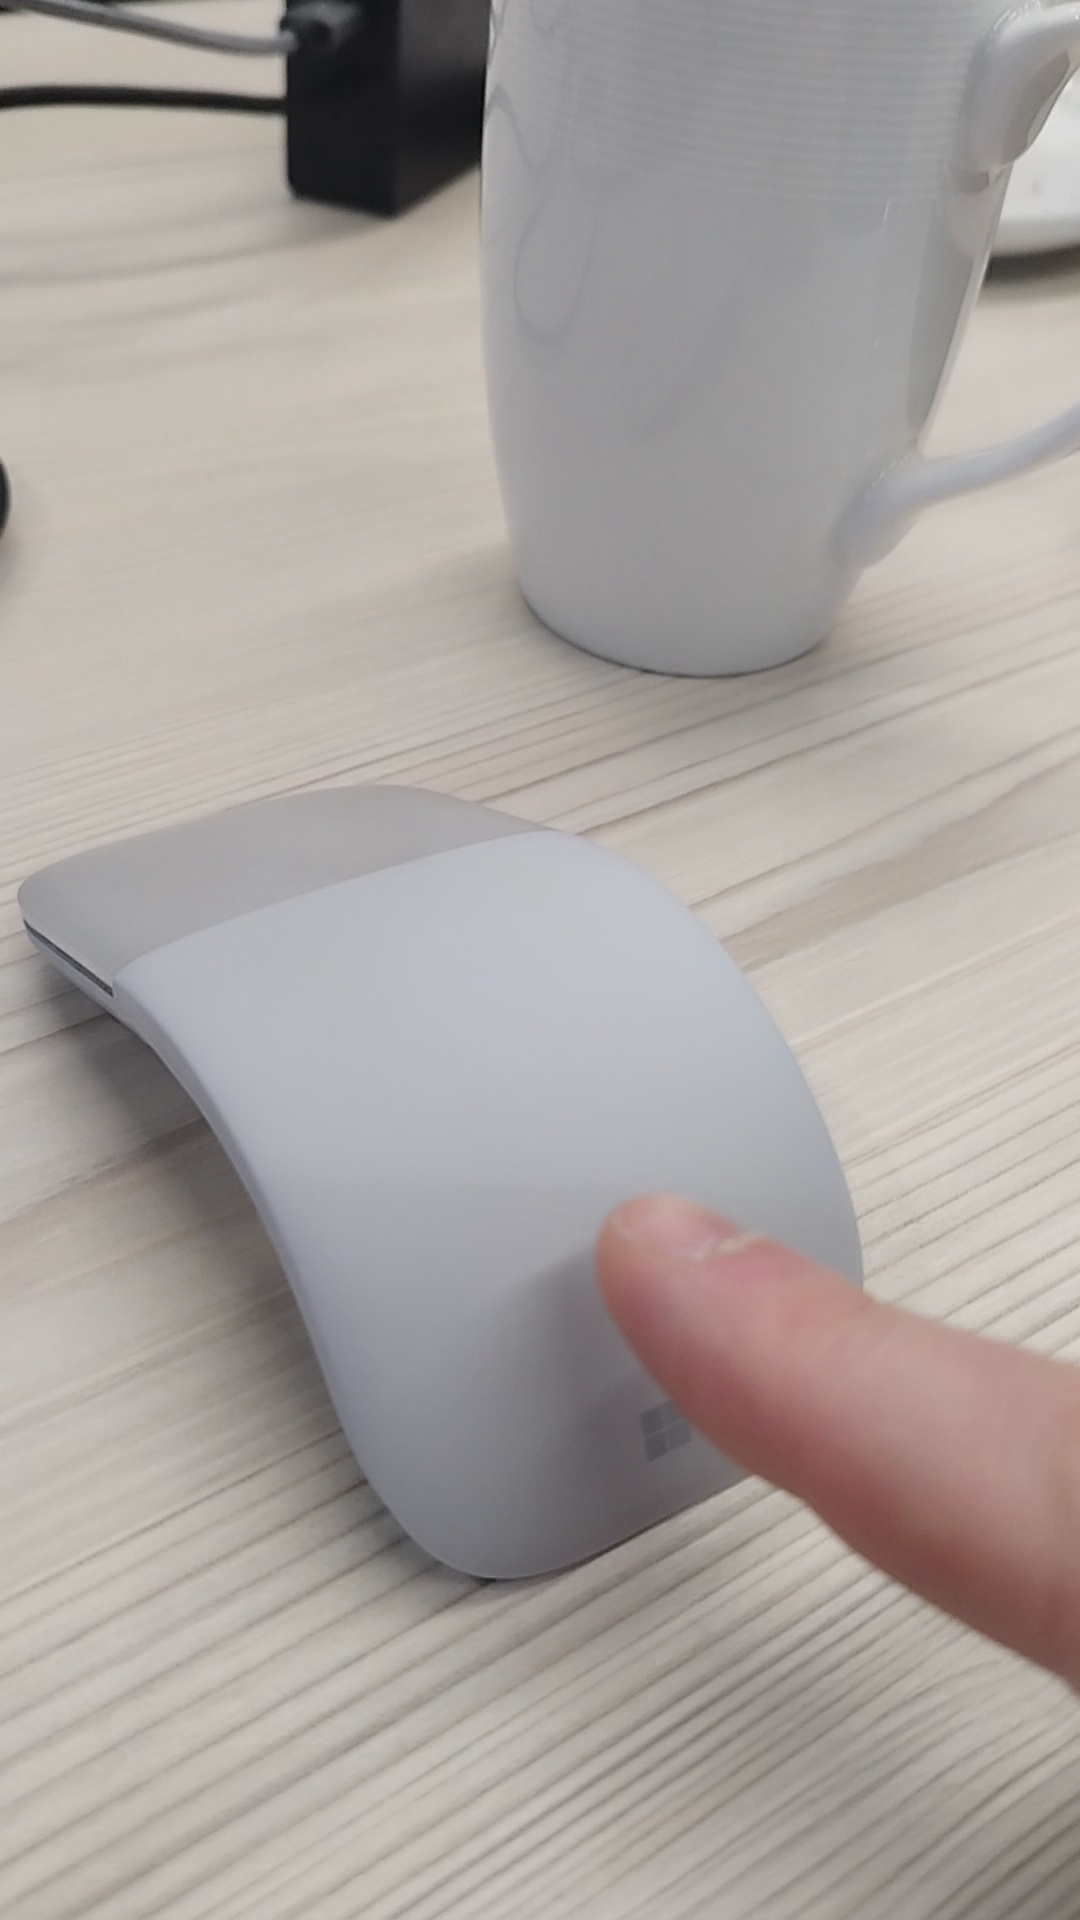

In [111]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)

In [24]:
import os
from openai import OpenAI
from dotenv import load_dotenv
import base64
import mimetypes
load_dotenv()

import os
import openai
openai.api_type = "azure"
openai.api_base = "https://rsaistudio-aiservices.openai.azure.com/"
openai.api_version = "2023-07-01-preview"
openai.api_key = open("AzureKeySwedenProject.txt","r").read()
openai.azure_endpoint = "https://rsaistudio-aiservices.openai.azure.com/"

PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames from a video that I want to upload. Describe what is happening in the video.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::50]),
        ],
    },
]
params = {
    "model": "gpt-4_v",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 200,
}

result = openai.chat.completions.create(**params)
print(result.choices[0].message.content)

Someone is clicking a computer mouse with their index finger.
